##Installs


In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 9.0 MB/s eta 0:00:00


##Imports


In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch
import torch.nn as nn
from pyro.infer import MCMC, NUTS
import numpy as np
import matplotlib.pyplot as plt
from pyro.infer import Predictive
import time

##Simple BNN class
This class represents a two hidden layer bayesian neural network. It uses ReLU/Tanh for activation.

In [ ]:
class BNN(PyroModule):
  def __init__(self, inp_dim=1, out_dim=1, hid_dim=5, pri_scl=5., activ="tanh"):
    super().__init__()
    self.activation=nn.Tanh()
    if(activ=="relu"):
      self.activation = nn.ReLU()
    self.layer1 = PyroModule[nn.Linear](inp_dim, hid_dim) #first hidden layer
    self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim) #second hidden layer
    self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim) #output layer

    #initialising layer configs
    self.layer1.weight = PyroSample(dist.Normal(0., pri_scl).expand([hid_dim, inp_dim]).to_event(2))
    self.layer1.bias = PyroSample(dist.Normal(0., pri_scl).expand([hid_dim]).to_event(1))

    self.layer2.weight = PyroSample(dist.Normal(0., pri_scl).expand([hid_dim, hid_dim]).to_event(2))
    self.layer2.bias = PyroSample(dist.Normal(0., pri_scl).expand([hid_dim]).to_event(1))

    self.layer3.weight = PyroSample(dist.Normal(0., pri_scl).expand([out_dim, hid_dim]).to_event(2))
    self.layer3.bias = PyroSample(dist.Normal(0., pri_scl).expand([out_dim]).to_event(1))

  def forward(self, x, y=None):
    x = x.reshape(-1, 1)
    x = self.activation(self.layer1(x))
    x = self.activation(self.layer2(x))
    mu = self.layer3(x).squeeze()
    sigma = pyro.sample("sigma", dist.Gamma(0.5, 1)) # for noise

    # for sampling
    with pyro.plate("data", x.shape[0]):  # pyro plate is a context manager for handling collection of data points
      obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)

    return mu

## Plotter

In [ ]:
def plot_data(preds, x_test, x_obs, y_obs, x_true, y_true):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    #setting the plot configs
    fig, ax = plt.subplots(figsize=(10,5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observed values")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#FF0000", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#FF7F7F', zorder=5)

    plt.legend(loc=4, fontsize=16, frameon=False)

## Data Generation
The function considered in this case is: $y = x + sin(\frac{\pi}{2}x) + cos(\pi x)$.

For this the samples ($x$) are randomly sampled from uniform distribution and corresponding $y$'s are computed after introducing some random noise (for $x\_obs$ and $y\_obs$).

In [ ]:
np.random.seed(int(time.time())) # random seed

# sampling observations
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(0.5 * np.pi * (x_obs + noise)) + 0.3 * np.cos(np.pi * (x_obs + noise)) + noise

# sampling the true points
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(0.5 * np.pi * x_true) + 0.3 * np.cos(np.pi * x_true)

## Model Training

In [ ]:
model = BNN()
pyro.set_rng_seed(int(time.time()))
nuts_kernel = NUTS(model, jit_compile=True) # NUTS kernel for Hamiltonian Monte Carlo (jit_compile makes it faster)
mcmc = MCMC(nuts_kernel, num_samples=100)
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()
mcmc.run(x_train, y_train)

Warmup:   0%|          | 0/200 [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 200/200 [08:14,  2.47s/it, step size=4.59e-04, acc. prob=0.957]


## Predictions

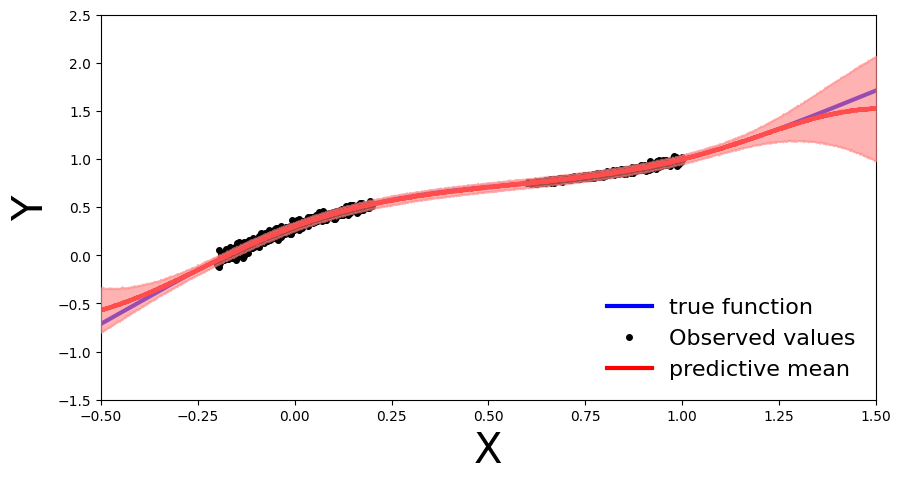

In [ ]:
pred_model = Predictive(model = model, posterior_samples=mcmc.get_samples())
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = pred_model(x_test)
plot_data(preds, x_test, x_obs, y_obs, x_true, y_true)